# Gun Violence Capstone Project

# Machine Learning

The goal of this notebook is to create a supervised machine learning algorithm that can predict the number of people killed/injured as a result of gun violence based on a number of feature variables.

**0. Begin by importing relevant packages and data wrangling code.**

In [1]:
# Packages
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv('Downloads/Data/gun-violence-data_01-2013_03-2018.csv', parse_dates=['date'])
df.drop(['incident_id','incident_url','source_url','incident_url_fields_missing','location_description','notes','participant_name','participant_relationship', 'sources', 'participant_status', 'address', 'latitude', 'longitude','participant_type','participant_age', 'gun_stolen', 'n_guns_involved', 'gun_type'], axis = 1, inplace = True)
df.dropna(how = 'any', subset = ['incident_characteristics', 'state_house_district', 'congressional_district', 'state_senate_district'], inplace = True)
df['participant_age_group'].fillna('0::Unknown', inplace = True)
def agegroup_cleanup(row):
    agegroup_row_values = []
    agegroup_row = str(row).split("||")
    for x in agegroup_row :
        agegroup_row_value = str(x).split("::")
        if len(agegroup_row_value) > 1 :
            agegroup_row_values.append(agegroup_row_value[1])
    return agegroup_row_values
agegroupvalues = df.participant_age_group.apply(agegroup_cleanup)
df["agegroup_child"] = agegroupvalues.apply(lambda x: x.count("Child 0-11"))
df["agegroup_teen"] = agegroupvalues.apply(lambda x: x.count("Teen 12-17"))
df["agegroup_adult"] = agegroupvalues.apply(lambda x: x.count("Adult 18+"))
df = df[df['incident_characteristics'].str.contains('Non-Shooting Incident') == False]
df['date'] = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['monthday'] = df.date.dt.day
df['weekday'] = df.date.dt.weekday
city_list = df['city_or_county'].value_counts().head(15).index.tolist()
df = df[df['city_or_county'].apply(lambda x: x in city_list)]
df['participant_gender'].fillna('0::Unknown', inplace = True)
def gender_cleanup(row):
    gender_row_values = []
    gender_row = str(row).split("||")
    for x in gender_row :
        gender_row_value = str(x).split("::")
        if len(gender_row_value) > 1 :
            gender_row_values.append(gender_row_value[1])   
    return gender_row_values
participant_genders = df.participant_gender.apply(gender_cleanup)
df["participant_gender_male"] = participant_genders.apply(lambda x: x.count("Male"))
df["participant_gender_female"] = participant_genders.apply(lambda x: x.count("Female"))
df['city_or_county'] = pd.Categorical(df.city_or_county)
df['mapped_cities'] = df.city_or_county.cat.codes
df.drop(['city_or_county','state','date','participant_gender','participant_age_group','incident_characteristics'], axis = 1, inplace = True)

**1. Select the feature and response variables**

- From performing inferential statistics and checking correlation between variables, we know which features we want to select to predict the number of people killed (n_killed) and the number of people injured (n_injured). 


- In the inferential statistics notebook, we've also turned the age-group and participant-gender columns into its own separate categorical columns. For age-group, we had 3 columns for child (people aged 0-11), teen (people aged 12-17) and adult (people aged 18+) and each one counted the number of times a person of that age group was part of the incident. For participant-gender, we had 3 columns for male, female and unknown (cases where the gender was unknown).


- We also used the pandas function pd.Categorical() to transform the column 'city_or_county' into a Categorical column where each value is represented by numbers. Ex. Chicago is no longer a string called 'Chicago' and is instead represented by the number 1.


- Through these steps, we've ensured that the feature variables will be numerical while retaining its original information.

In [3]:
# Select feature variables and store them as a numpy array
X = df.drop('n_killed',axis = 1)
X_col = X.columns
X = X.values

X2 = df.drop('n_injured', axis = 1)
X2_col = X2.columns
X2 = X2.values

# Select response variables and store them as a numpy array
y = df['n_killed'].values
y2 = df['n_injured'].values

- (Note: We will be creating 2 sets of feature and response variables in order to test for the number of deaths and number of injuries seperately.)

**2. Pre-processing the Data**

- Before we dive right into creating our classifiers, we will need to pre-process the data beyond just filling in missing data and converting categorical columns. An important aspect of machine learning is the concept of standardization, where we determine whether or not the features should be scaled in a similar fashion or if they're better left untouched. Let's begin by observing the mean and standard deviation of the features before and after applying the scale function.

In [4]:
X_scaled = scale(X)
print("Mean of Unscaled Features (n_killed): \n{0:.4f}".format(np.mean(X))) 
print("\nStandard Deviation of Unscaled Features (n_killed): \n{0:.4f}".format(np.std(X)))
print("\nMean of Scaled Features (n_killed): \n{0:.4f}".format(np.mean(X_scaled))) 
print("\nStandard Deviation of Scaled Features (n_killed): \n{0:.4f}".format(np.std(X_scaled)))

Mean of Unscaled Features (n_killed): 
150.9637

Standard Deviation of Unscaled Features (n_killed): 
517.4232

Mean of Scaled Features (n_killed): 
0.0000

Standard Deviation of Scaled Features (n_killed): 
1.0000


In [5]:
X_scaled = scale(X2)
print("Mean of Unscaled Features (n_injured): \n{0:.4f}".format(np.mean(X2))) 
print("\nStandard Deviation of Unscaled Features (n_injured): \n{0:.4f}".format(np.std(X2)))
print("\nMean of Scaled Features (n_injured): \n{0:.4f}".format(np.mean(X_scaled))) 
print("\nStandard Deviation of Scaled Features (n_injured): \n{0:.4f}".format(np.std(X_scaled)))

Mean of Unscaled Features (n_injured): 
150.9294

Standard Deviation of Unscaled Features (n_injured): 
517.4332

Mean of Scaled Features (n_injured): 
0.0000

Standard Deviation of Scaled Features (n_injured): 
1.0000


- As we can see, there was a relatively large standard deviation among the features. This implies that the scaling between the columns was vastly different from one another. To prove this point, we can take a peek at a few features whose scaling are totally different.

In [6]:
df[['n_injured','state_house_district','agegroup_adult','mapped_cities']].head()

,n_injured,state_house_district,agegroup_adult,mapped_cities
7,5,93.0,0,12
11,3,76.0,1,14
15,5,84.0,5,10
17,4,25.0,6,1
18,4,93.0,7,12


- Whereas n_injured mostly has values ranging from 0 to 5, a feature like state_house_district has values jumping all over the place due to its categorical nature. It would be an egregious mistake to assume that the data does not need scaling. 

**3. Using Linear Regression with Regularization (Lasso and Ridge)**

- Let's begin by using the most standard regression classifier: **Linear Regression**. It's very simple since it does not require any hyperparameters. 

- First we will create a baseline using the DummyRegressor function and set the strategy to 'mean'. This will give us a way to check how accurate the predictions are.

In [7]:
# Finding the baseline for the dataset.
# Begin by creating the pipeline steps. Start with scaling the data via StandardScaler and then the DummyRegressor estimator
steps = [('scaler', StandardScaler()), ('clf', DummyRegressor(strategy='mean'))]
pipeline = Pipeline(steps)
# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# Fit the data into the pipeline
pipeline.fit(X_train,y_train)
# Predict the response variables using the test data
y_pred = pipeline.predict(X_test)

# Computing the baseline R-squared
print('Baseline R-squared (n_killed): {0:.4f}'.format(pipeline.score(X_test, y_test)))

#Computing the baseline RMSE
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Baseline Root Mean Squared Error (n_killed): {0:.4f}'.format(rmse))
cv_scores = cross_val_score(pipeline,X,y,cv=10)
print("Baseline Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Repeat the steps for n_injured
steps = [('scaler', StandardScaler()), ('clf', DummyRegressor(strategy='mean'))]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, random_state = 23)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print('\nBaseline R-squared (n_injured): {0:.5f}'.format(pipeline.score(X_test, y_test)))
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Baseline Root Mean Squared Error (n_injured): {0:.4f}'.format(rmse))
cv_scores = cross_val_score(pipeline,X2,y2,cv=10)
print("Baseline Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores)))

Baseline R-squared (n_killed): -0.0001
Baseline Root Mean Squared Error (n_killed): 0.5067
Baseline Average 10-Fold CV Score (n_killed): -0.0053

Baseline R-squared (n_injured): -0.00002
Baseline Root Mean Squared Error (n_injured): 0.7654
Baseline Average 10-Fold CV Score (n_injured): -0.0126


- Our baseline r-squared for n_killed is -0.0001 and our baseline RMSE is 0.5067. 


- Our baseline r-squared for n_injured is -0.00002 and our baseline RMSE is 0.7654. 


- Although the r-squared seems bad, it's important to remember it only serves as a baseline against which we can compare the results of our models.

In [8]:
steps = [('scaler', StandardScaler()), ('reg', LinearRegression())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Measure the accuracy of the predictions by finding the R-squared and root mean squared error
print("R-squared (n_killed): {0:.4f}".format(pipeline.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
# Use Cross-Validation to better understand the model's performance using k-folds
cv_scores = cross_val_score(pipeline,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Repeat the steps for n_injured
steps = [('scaler', StandardScaler()), ('reg', LinearRegression())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 1)
pipeline2.fit(X_train2, y_train2)
y_pred2 = pipeline2.predict(X_test2)
print("\nR-squared (n_injured): {0:.4f}".format(pipeline2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(pipeline,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.3193
Root Mean Squared Error (n_killed): 0.4123
Average 10-Fold CV Score (n_killed): 0.2905

R-squared (n_injured): 0.4207
Root Mean Squared Error (n_injured): 0.6005
Average 10-Fold CV Score (n_injured): 0.3969


- By comparing the results of the linear regression to the n_killed baseline, we can see that the r-squared of 0.3193 and RMSE of 0.4123 are better than the baseline.


- Similarly for n_injured, the r-squared of 0.4207 and RMSE of 0.6005 are better than the baseline.


- Let's plot the predicted versus the actual response values so that we can see how well the linear regression model performed from a visual standpoint.

In [9]:
#reg_coef = pipeline.named_steps['reg'].coef_
#reg_coef2 = pipeline2.named_steps['reg'].coef_

#sns.set()
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))
#ax1.scatter(y_pred,y_test,marker='.')
#ax1.set_title('Predicted vs Actual (n_killed)')
#ax1.set_xlabel('Predicted n_killed values')
#ax1.set_ylabel('Actual n_killed values')

#ax2.scatter(y_pred2,y_test2,marker='.')
#ax2.set_title('Predicted vs Actual (n_injured)')
#ax2.set_xlabel('Predicted n_injured values')
#ax2.set_ylabel('Actual n_injured values')

#ax3.plot(range(len(X_col)),reg_coef)
#ax3.set_title('Feature Coefficients (n_killed)')
#ax3.set_xticklabels(X_col, rotation = 60)
#ax3.set_xlabel('Feature Variables (n_killed)')
#ax3.set_ylabel('Coefficient Values (n_killed)')

#ax4.plot(range(len(X2_col)),reg_coef2)
#ax4.set_title('Feature Coefficients (n_injured)')
#ax4.set_xlabel('Feature Variables (n_injured)')
#ax4.set_ylabel('Coefficient Values (n_injured)')

#plt.tight_layout()

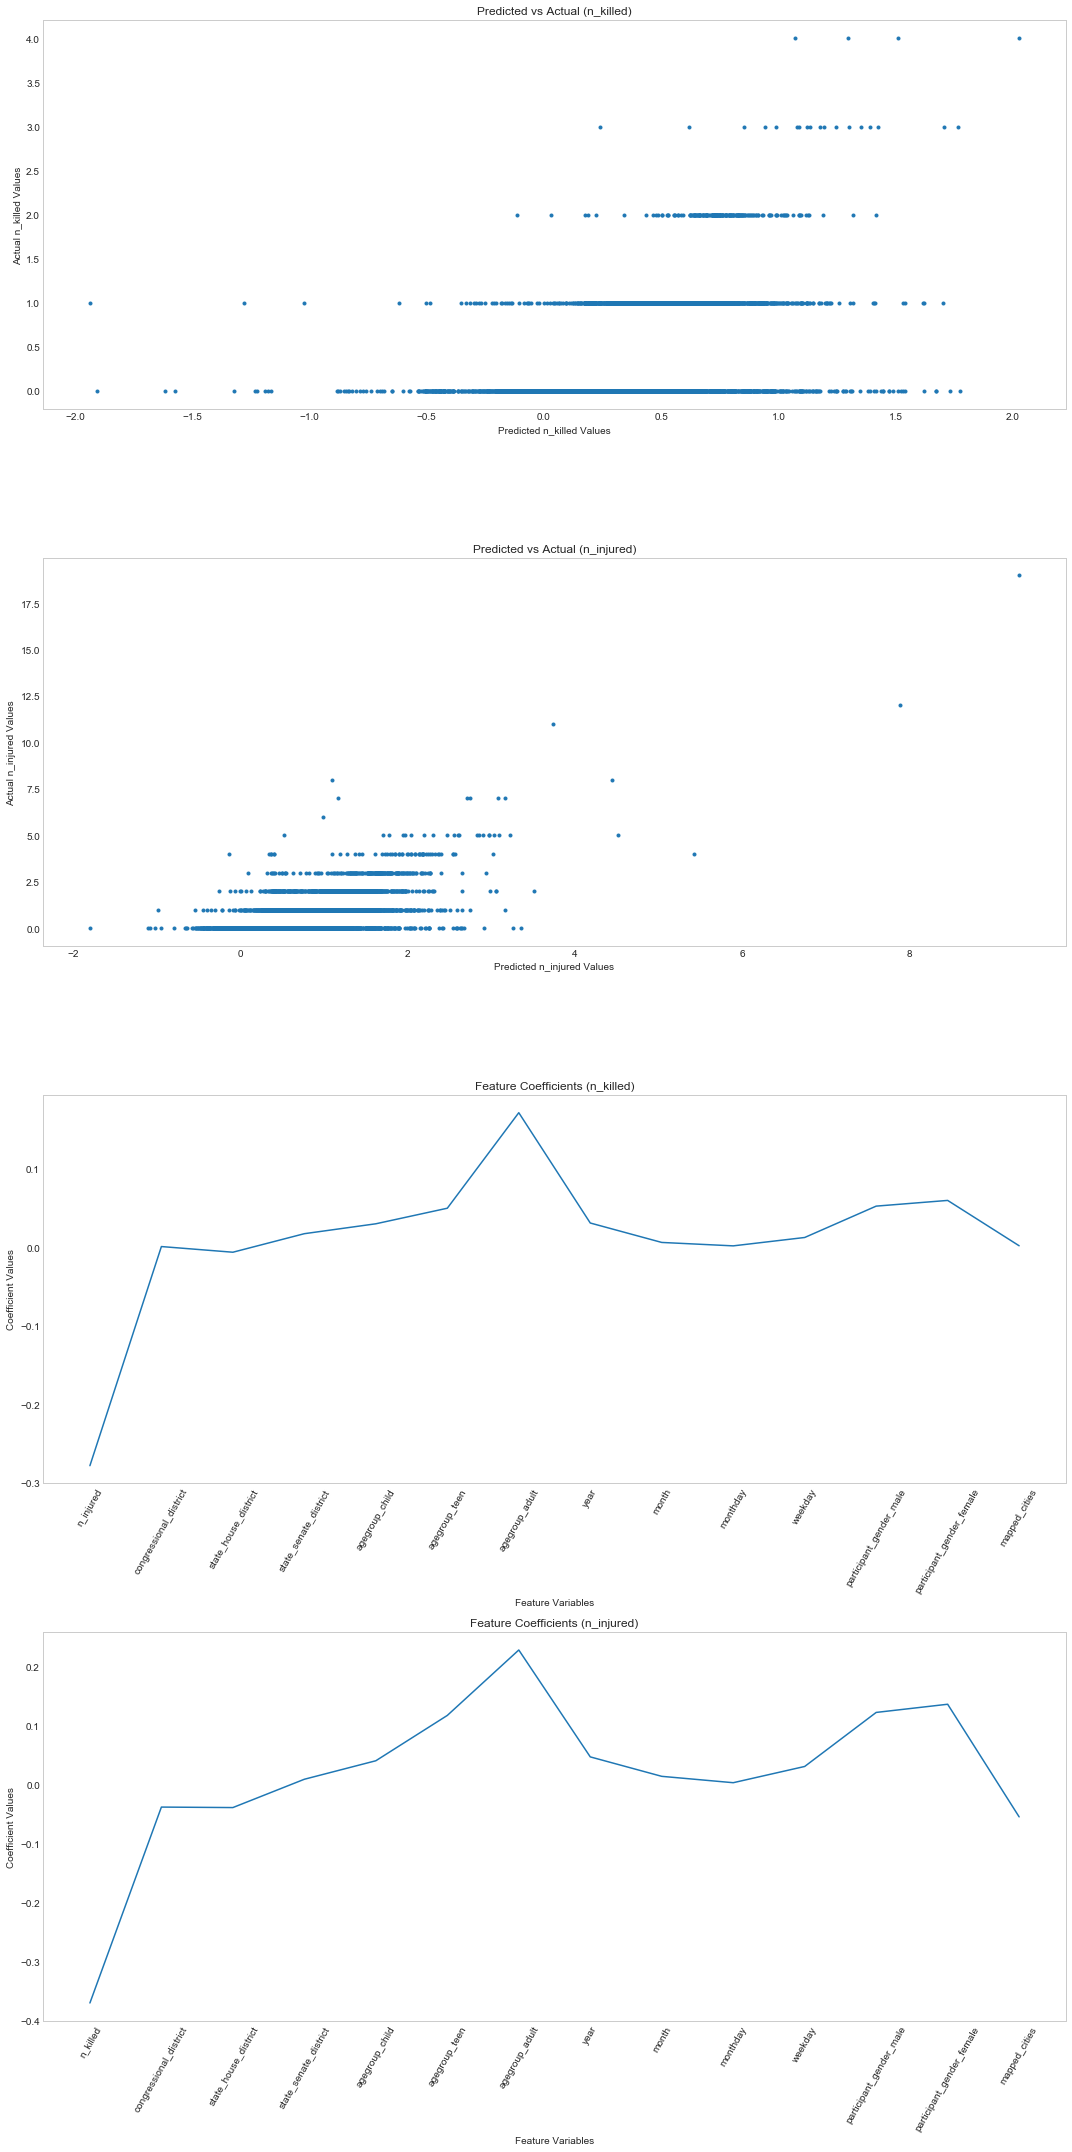

In [10]:
# Use a scatter plot to display the predicted vs actual values
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
reg_coef = pipeline.named_steps['reg'].coef_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),reg_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
reg_coef2 = pipeline2.named_steps['reg'].coef_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),reg_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- There are a few takeaways from the predicted vs actual plots. First, the model predicted quite a few negative values for n_killed and n_injured, which is practically impossible. Secondly, the model did not predict any values greater than 2 for n_killed nor did it predict any values greater than 10 for n_injured. It also used floating point numbers instead of only integer values. This shows the limitations of the Linear Regression model.


- The model also set most of the coefficients close to 0. In fact, the only variables that had a coefficient absolute value greater than 0.2 were n_injured when n_killed was the response variable and n_killed when n_injured was the response variable. In both cases, they had negative correlations which implies they have an inverse relationship. On average, if we assume that there is a fixed number of casualties per incident, it makes sense that with more injuries, there will be fewer deaths and vice versa.


- Next, let's use the **Lasso Regularization** and **Ridge Regularization** on the data to help compensate for the possibility of overfitting. For these classifiers, we will be specifying the hyperparameter alpha, which multiples the L1 term. In order to decide which alpha to use, we will be using **GridSearchCV** to iterate over a list of values for alpha. This will return the best alpha value and its "score".

In [11]:
steps = [('scaler', StandardScaler()), ('lasso', Lasso())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)
# Define the parameter values that will be searched
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
# Create the parameter grid
param_grid = {'lasso__alpha':alphas}
# Instantiate the grid search
gscv = GridSearchCV(pipeline, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
# Fit the training data into the model
gscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is (n_killed):{0:.4f}'.format(gscv.best_score_))
print('The best parameters are (n_killed):',gscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('lasso', Lasso())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 20)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'lasso__alpha':alphas}
gscv2 = GridSearchCV(pipeline2, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(gscv2.best_score_))
print('The best parameters are (n_injured):',gscv2.best_params_)

The best score is (n_killed):0.3216
The best parameters are (n_killed): {'lasso__alpha': 0.001}

The best score is (n_injured):0.3945
The best parameters are (n_injured): {'lasso__alpha': 0.001}


In [12]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
# (Note: The attribute .best_estimator_ returns the Lasso classifier with the optimal parameters)
best_lasso = gscv.best_estimator_
y_pred = best_lasso.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_lasso.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_lasso,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_lasso2 = gscv2.best_estimator_
y_pred2 = best_lasso2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_lasso2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_lasso2,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.3123
Root Mean Squared Error (n_killed): 0.4112
Average 10-Fold CV Score (n_killed): 0.2911

R-squared (n_injured): 0.4279
Root Mean Squared Error (n_injured): 0.5809
Average 10-Fold CV Score (n_injured): 0.3968


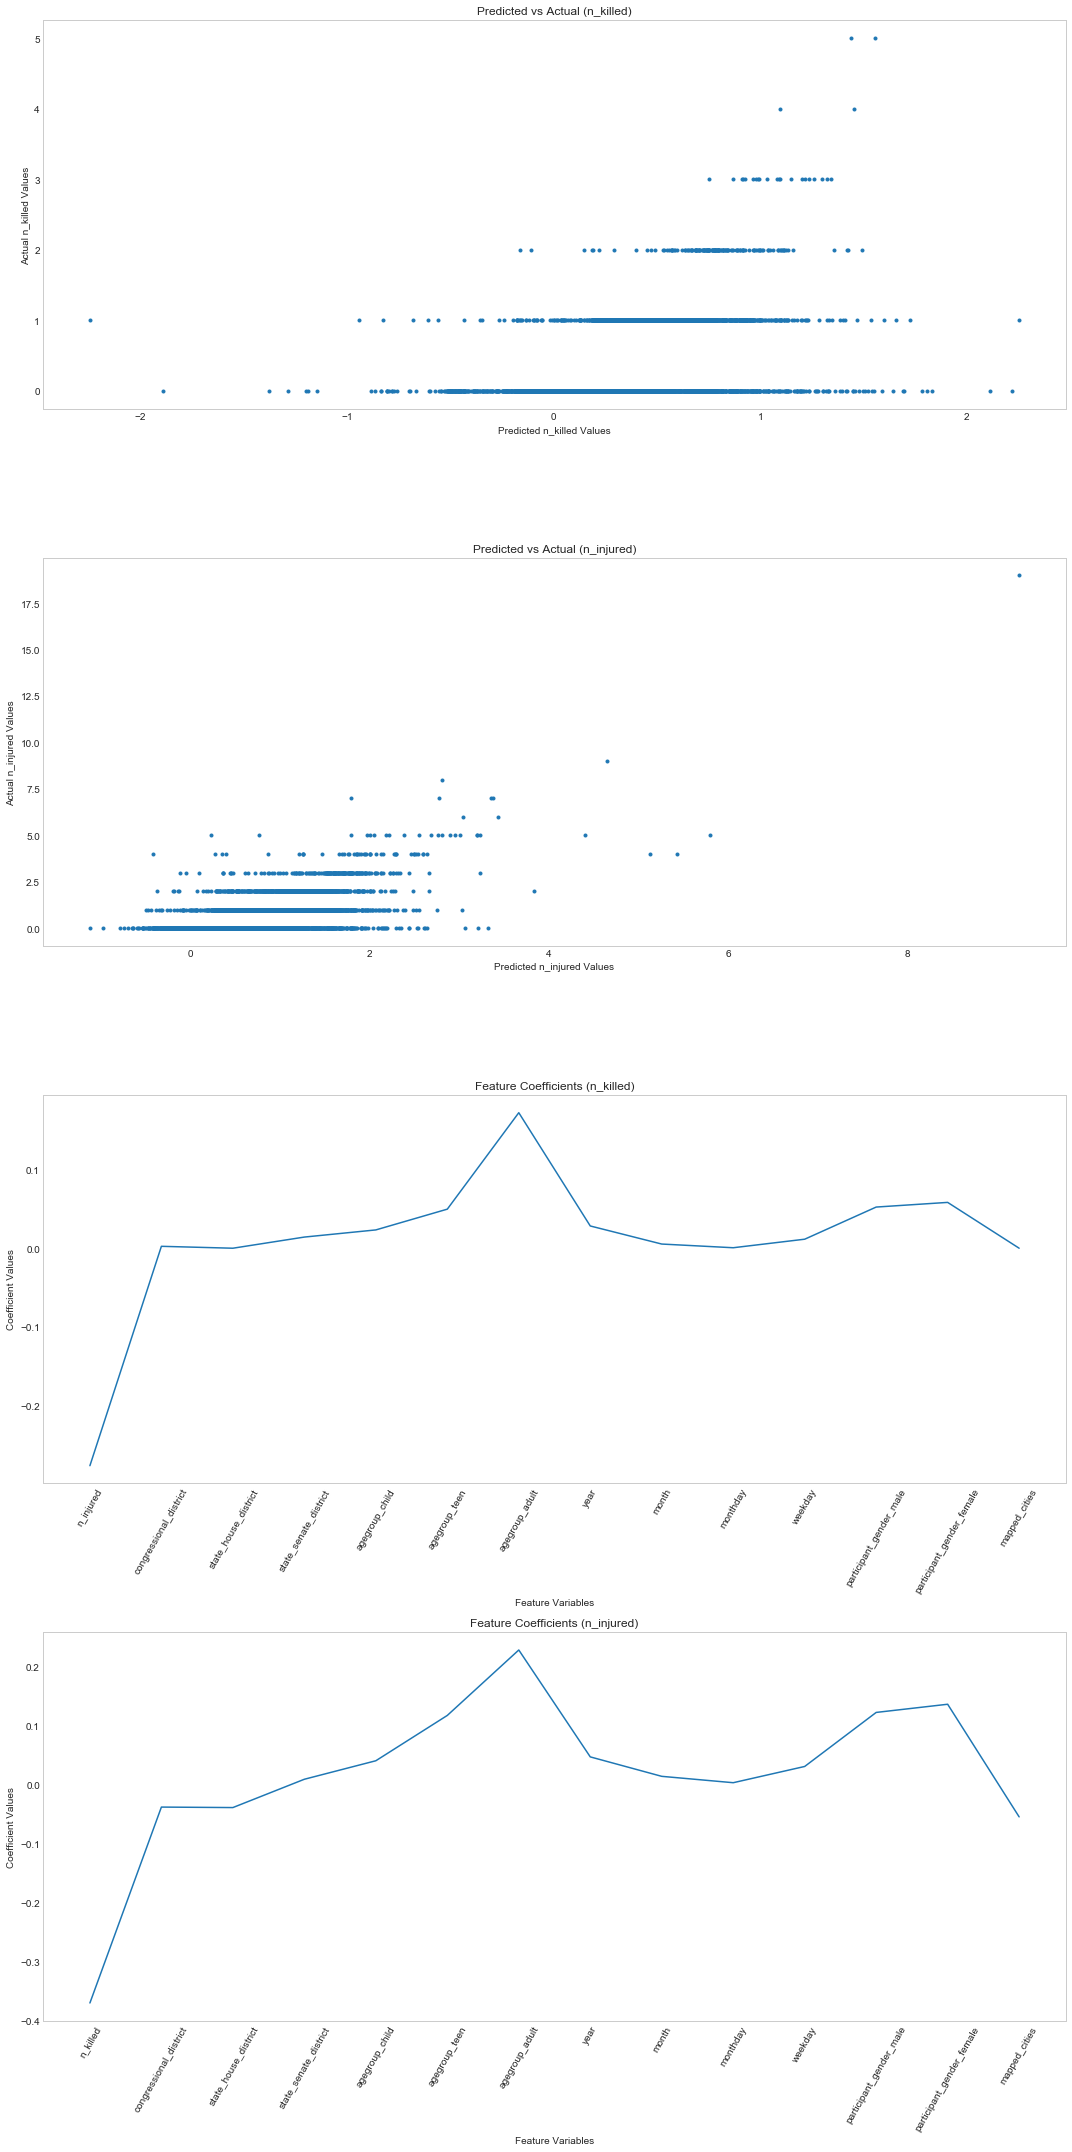

In [13]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
lasso_coef = best_lasso.fit(X,y).named_steps['lasso'].coef_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),lasso_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
lasso_coef2 = best_lasso2.fit(X2,y2).named_steps['lasso'].coef_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),reg_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the R-squared score for Lasso (0.3123 vs 0.3193) became worse compared to the Linear Regression model *without* any regularization. However, the RMSE (0.4112 vs 0.4123) did slightly improve. Overall, it's still better than the baseline. 


- For *n_injured*, the R-squared score slightly improved for Lasso (0.4279 vs 0.4207) as well as the RMSE score (0.5809 vs 0.6005).


- We will next use the Ridge regularization to see if there are any improvements on the model.

In [14]:
steps = [('scaler', StandardScaler()), ('ridge', Ridge())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'ridge__alpha':alphas}
gscv = GridSearchCV(pipeline, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv.fit(X_train, y_train)
print('The best score is (n_killed):{0:.4f}'.format(gscv.best_score_))
print('The best parameters are (n_killed):',gscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('ridge', Lasso())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 30)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'ridge__alpha':alphas}
gscv2 = GridSearchCV(pipeline2, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(gscv2.best_score_))
print('The best parameters are (n_injured):',gscv2.best_params_)

The best score is (n_killed):0.3278
The best parameters are (n_killed): {'ridge__alpha': 10}

The best score is (n_injured):0.3832
The best parameters are (n_injured): {'ridge__alpha': 0.001}


In [15]:
best_ridge = gscv.best_estimator_
y_pred = best_ridge.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_ridge.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_ridge,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_ridge2 = gscv2.best_estimator_
y_pred2 = best_ridge2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_ridge2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_ridge2,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.2973
Root Mean Squared Error (n_killed): 0.4144
Average 10-Fold CV Score (n_killed): 0.2906

R-squared (n_injured): 0.4437
Root Mean Squared Error (n_injured): 0.5993
Average 10-Fold CV Score (n_injured): 0.3968


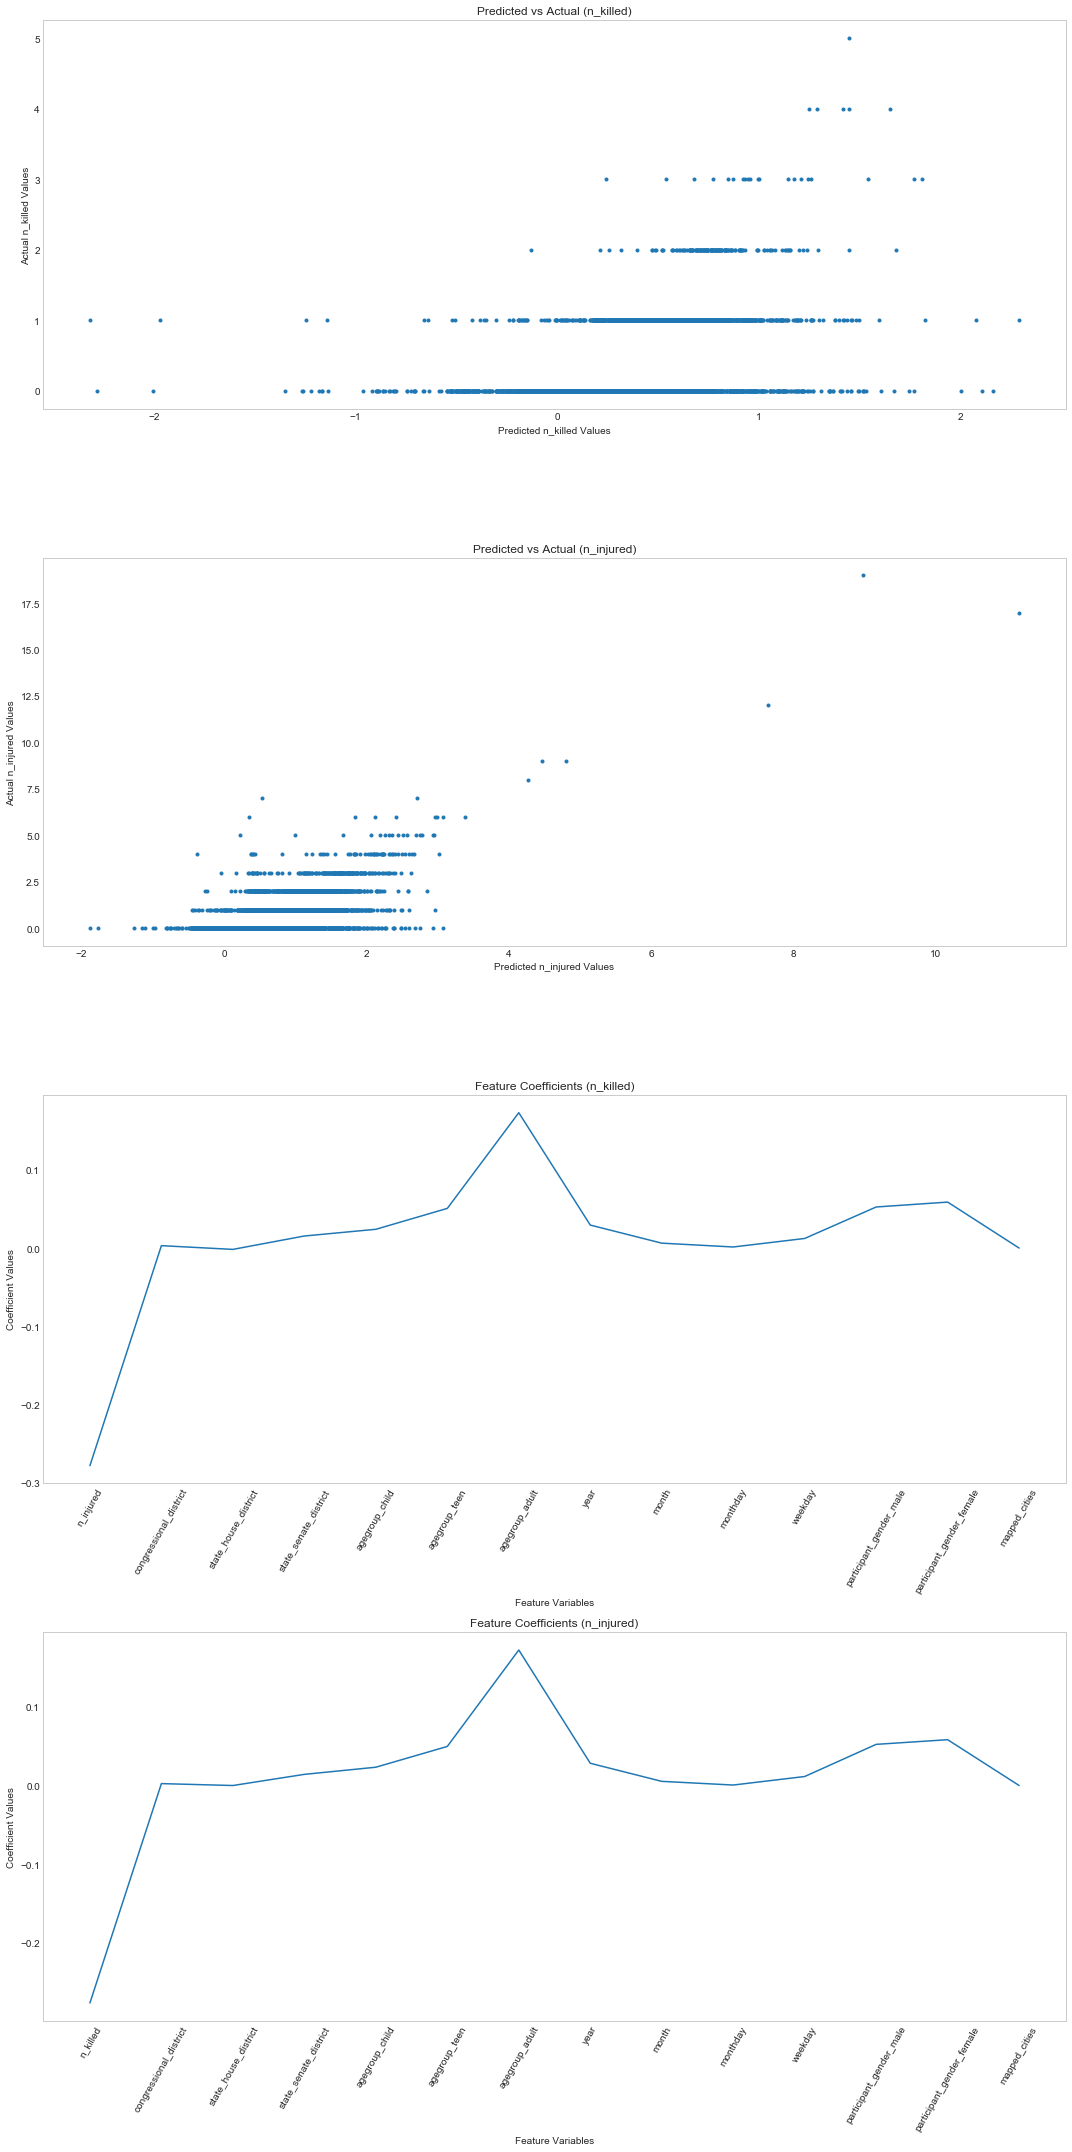

In [16]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
ridge_coef = best_ridge.fit(X,y).named_steps['ridge'].coef_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),ridge_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
ridge_coef2 = best_ridge2.fit(X,y).named_steps['ridge'].coef_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),ridge_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, all 3 regression models (Linear without regularization, Linear with Lasso, Linear with Ridge) had relatively similar RMSE scores but their R-Squared scores were noticeably different. Linear without any regularization had the best r-squared score at 0.3193 and the best RMSE at 0.4123.


- When looking at the predicted vs actual plots, all 3 models looked similar in their distribution of values. They all had a majority of their values fit between -2 and 2. The feature coefficients plots of all 3 methods were practically the same with only minute differences in the coefficient values. 


- For *n_injured*, both regularization methods improved the Linear Regression model. Ridge regularization had the best R-Squared score (0.4437) while Lasso regularization had the best RMSE (0.5809).


- The feature coefficients plots of the Linear Regression without regularization and Linear Regression with Lasso regularization were very similar. However, the plot of Ridge regularization was different and almost identical to the Ridge regularization plot for n_killed.

In [17]:
#from sklearn.linear_model import ElasticNet

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 31)
#alphas = [0.01, 0.1, 1, 10, 100]
#l1_space = np.linspace(0, 1, 10)
#param_grid = {'alpha':alphas,'l1_ratio': l1_space}
#elastic_net = ElasticNet() 
#gscv = GridSearchCV(elastic_net, param_grid, scoring = 'r2', n_jobs = -1, cv=10) 
#gscv.fit(X_train, y_train)

#print('The best score is:',gscv.best_score_)
#print('The best parameters are:',gscv.best_params_)

**4. Using the Decision Tree Regressor**

The next step is to seek the best hyperparameters for our models using **RandomizedSearchCV**, which is very similar to its cousin GridSearchCV except it instead randomly selects parameters to test. From there we can choose the best parameters that result in the best r-squared score. 

For our next classifer, we will use the **Decision Tree Regressor**, which predicts the response variable values by learning simple decision rules inferred from the feature data. RandomizedSearchCV is preferred over GridSearchCV in this scenario since there are going to be more parameter values to iterate over. Thus it will save computation time.

In [18]:
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 876)

# Define the parameter values that will be randomly searched
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
# Create the parameter grid
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
# Instantiate random search
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
# Fit the training data into the model
rscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 876)
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
rscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.4942
The best parameters are (n_killed): {'tree__min_samples_split': 2, 'tree__min_samples_leaf': 1, 'tree__max_depth': 8}

The best score is (n_injured):0.4503
The best parameters are (n_injured): {'tree__min_samples_split': 3, 'tree__min_samples_leaf': 1, 'tree__max_depth': 8}


In [19]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
best_tree = rscv.best_estimator_
y_pred = best_tree.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_tree.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_tree,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_tree2 = rscv2.best_estimator_
y_pred2 = best_tree2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_tree2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_tree,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.5220
Root Mean Squared Error (n_killed): 0.3473
Average 10-Fold CV Score (n_killed): 0.4929

R-squared (n_injured): 0.4713
Root Mean Squared Error (n_injured): 0.5688
Average 10-Fold CV Score (n_injured): 0.4461


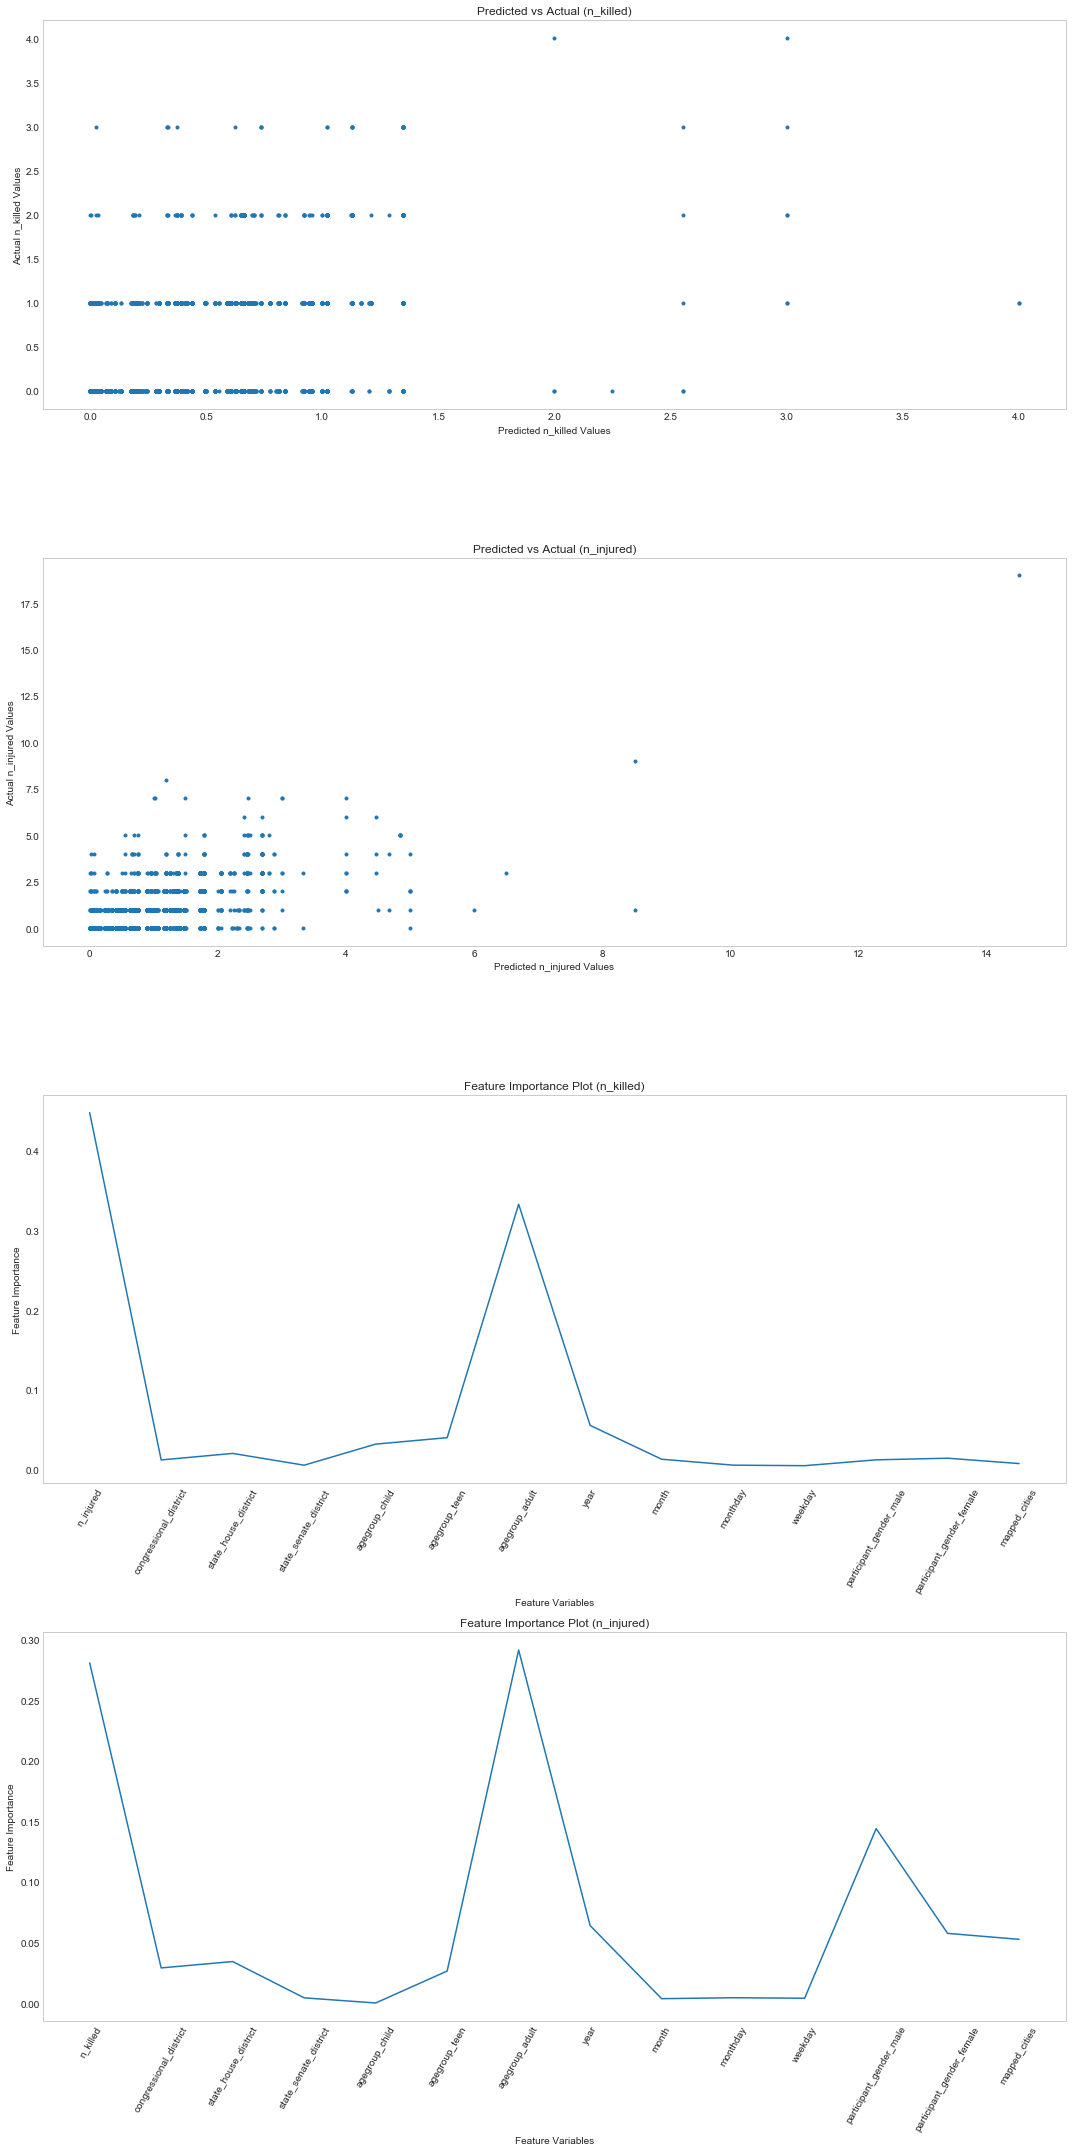

In [20]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
tree_coef = best_tree.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),tree_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Feature Importance')
_ = plt.title('Feature Importance Plot (n_killed)')

# Do the same for n_injured
tree_coef2 = best_tree2.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),tree_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Feature Importance')
_ = plt.title('Feature Importance Plot (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the r-squared and RMSE scores have greatly improved using Decision Trees compared to the regression methods. The best results using the linear regressors was 0.3193 R-Squared and 0.4123 RMSE using the Linear Regressor. Using the Decision Tree with RandomizedSearchCV, however, resulted in a 0.5220 R-Squared score and 0.3473 RMSE. 


- The predicted vs actual plot shows that there are no longer any negative values and there are fewer deviations (more space in between the points). However, it still does a poor job of predicting outliers (values greater than 2). 


- As for the feature coefficients plot, the decision tree put an increased amount of weight on the number of injuries and number of adults while putting less weight elsewhere. This may be the main reason why there was a big change in the r-squared/RMSE. 


- For *n_injured*, the R-Squared and RMSE scores have also improved using Decision Trees, but not as much as n_killed. The best results using the linear regressors was 0.4437 R-Squared and 0.5809 RMSE. It jumped to 0.4713 R-Squared and lowered to 0.5688 RMSE after using the Decision Tree. 


- The predicted vs actual plot shows no more negative values but only shows 2 values greater than 6, which is probably the reason why it did not have as big of an improvement as n_killed. Outliers make this model inefficient for n_injured.


- The feature importance plot for n_injured shows that the Decision Tree model put the most weight on the number of deaths feature and number of adults (both nearly have 0.3 feature importance). The number of male participants also has a considerable amount of impact with nearly 0.15 feature importance.

**5. Using the Random Forest Ensemble**

Finally, let's use the **Random Forest** algorithm, which is an ensemble method which uses multiple decision trees. Each tree is built from a sample drawn with replacement (ex. a bootstrap sample) from the training set.

In [21]:
# Select feature variables and store them as a numpy array
X = df.drop('n_killed',axis = 1)
X_col = X.columns

X2 = df.drop('n_injured', axis = 1)
X2_col = X2.columns

# Select response variables and store them as a numpy array
y = df['n_killed']
y2 = df['n_injured']

In [22]:
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
    
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv.fit(X_train, y_train)
    
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 6)
    
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv2.fit(X_train2, y_train2)
    
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.5410
The best parameters are (n_killed): {'rf__n_estimators': 89, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 4, 'rf__max_depth': 26, 'rf__bootstrap': True}

The best score is (n_injured):0.5192
The best parameters are (n_injured): {'rf__n_estimators': 91, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 1, 'rf__max_depth': 15, 'rf__bootstrap': True}


In [23]:
best_rf = rscv.best_estimator_
y_pred = best_rf.predict(X_test)
print('\nR-squared (n_killed): {0:.4f}'.format(best_rf.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_rf,X,y,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_rf2 = rscv2.best_estimator_
y_pred2 = best_rf2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_rf2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_rf2,X2,y2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))


R-squared (n_killed): 0.5398
Root Mean Squared Error (n_killed): 0.3401
Average 10-Fold CV Score (n_killed): 0.5141

R-squared (n_injured): 0.5110
Root Mean Squared Error (n_injured): 0.5379
Average 10-Fold CV Score (n_injured): 0.4956


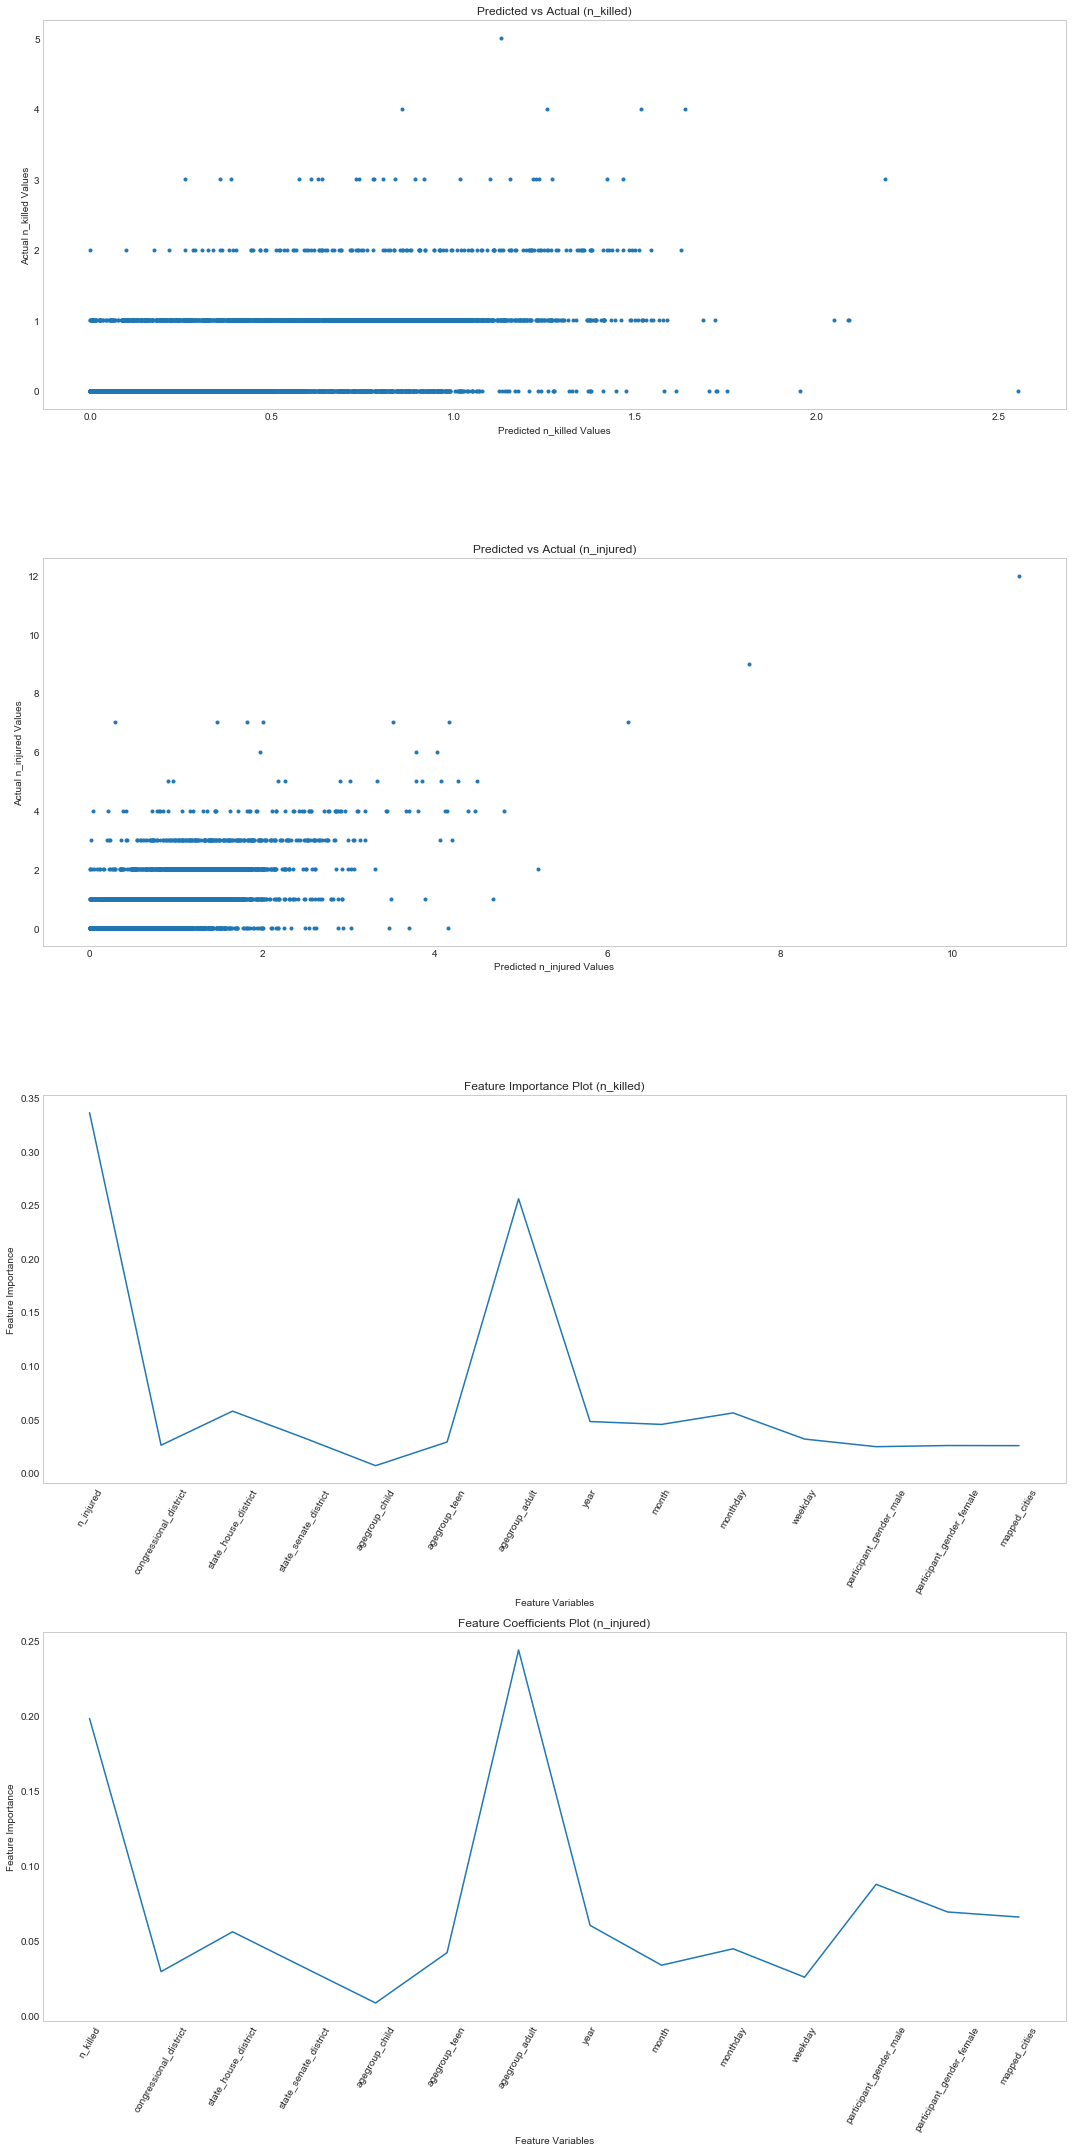

In [24]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
rf_coef = best_rf.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(X_col)),rf_coef)
_ = plt.xticks(range(len(X_col)),X_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Feature Importance')
_ = plt.title('Feature Importance Plot (n_killed)')

# Do the same for n_injured
rf_coef2 = best_rf2.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(X2_col)),rf_coef2)
_ = plt.xticks(range(len(X2_col)),X2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Feature Importance')
_ = plt.title('Feature Coefficients Plot (n_injured)')

_ = plt.tight_layout()

In [25]:
#fig = plt.figure(figsize = (15,6))

#X3_col = ['n_killed/n_injured', 
#        'congressional_district', 
#        'state_house_district','state_senate_district',
#        'agegroup_child','agegroup_teen','agegroup_adult',
#        'year','month','monthday','weekday',
#        'participant_gender_male','participant_gender_female','mapped_cities']

#_ = plt.plot(range(len(X2_col)),rf_coef2, label = 'n_injured')
#_ = plt.plot(range(len(X_col)),rf_coef, label = 'n_killed')
#_ = plt.xticks(range(len(X2_col)),X3_col,rotation=60)
#_ = plt.xlabel('Feature Variables')
#_ = plt.ylabel('Coefficient Values')
#_ = plt.legend()
#_ = plt.title('Feature Coefficients')
#_ = plt.savefig('Downloads/gv_eda19.png', bbox_inches = 'tight')

#_ = plt.tight_layout()

- For *n_killed*, using random forest had a slightly better r-squared (0.5398 vs 0.5220) and RMSE (0.3401 vs 0.3473) scores than using the decision tree model.


- Looking at the predicted vs actual plot, we can see that it has greater variance in the range of points compared to the Decision Tree model. For the feature coefficients plot, it is nearly identical to that of the decision tree model, showing that the best predictor features are indeed the incident characteristics. Compared to the Decision Tree model, the random forest model puts more weight on participant_gender_female.


- For *n_injured*, the Random Forest model showed a small improvement over the Decision Tree model. Its R-Squared score increased to 0.5110 and its RMSE dropped to 0.5379.


- There is now a greater distribution of points in the predicted vs actual plot, similar to what happened to n_killed after using the Random Forest model to generate predictions. There are also a few more outliers as indicated by the fact that there are 5 predicted points whose values are greater than 6. For the feature coefficients plot, it is about the same as the plot from the decision tree model. 

**6. Optimizing the model by removing outliers and noisy features**

- One of the reoccuring issues that's been on-going with all the models has been the outliers in the data. To create a better algorithm for predicting n_killed and n_injured, we will need to drop the outliers to prevent overfitting. First, let's see exactly what the threshold for outliers is by using at the probability distribution of the number of people killed and injured.

In [26]:
# Create a list of all the n_killed values and use a for-loop function to create a new list that contains the count and its
# proportion of total incidents 
outlier_test = [0,1,2,3,4,5,8]
outlier_ = []
outlier_list = []
outlier_perc = []
outlier_cdf = []
c = 0
for x in outlier_test:
    a = len(df[df['n_killed']==x])
    b = a/len(df)
    b = round(b,4)
    outlier_.append(x)
    outlier_list.append(a)
    outlier_perc.append(b)
    c += b
    outlier_cdf.append(c)
    
outlier_dict = {'n_killed value':outlier_, 'Count':outlier_list, 'Proportion':outlier_perc, '_CDF':outlier_cdf}
pd.DataFrame(outlier_dict).set_index('n_killed value')

,Count,Proportion,_CDF
n_killed value,,,
0,26357,0.7377,0.7377
1,8697,0.2434,0.9811
2,579,0.0162,0.9973
3,75,0.0021,0.9994
4,13,0.0004,0.9998
5,5,0.0001,0.9999
8,1,0.0000,0.9999


- Less than 99.7% of the incidents result in 3 or more deaths. This is the clear threshold for outliers because of its miniscule probability.

In [27]:
# Repeat the same process for n_injured
outlier_test2 = list(range(0,20))
outlier_2 = []
outlier_list2 = []
outlier_perc2 = []
outlier_cdf2 = []
c = 0
for x in outlier_test2:
    a = len(df[df['n_injured']==x])
    b = a/len(df)
    b = round(b,4)
    outlier_2.append(x)
    outlier_list2.append(a)
    outlier_perc2.append(b)
    c += b
    outlier_cdf2.append(c)

outlier_dict2 = {'n_injured value':outlier_2, 'Count':outlier_list2, 'Proportion':outlier_perc2, '_CDF':outlier_cdf2}
pd.DataFrame(outlier_dict2).set_index('n_injured value')

,Count,Proportion,_CDF
n_injured value,,,
0,13462,0.3768,0.3768
1,18598,0.5206,0.8974
2,2767,0.0774,0.9748
3,630,0.0176,0.9924
4,164,0.0046,0.9970
5,63,0.0018,0.9988
6,15,0.0004,0.9992
7,16,0.0004,0.9996
8,4,0.0001,0.9997


- Less than 99.2% of incidents result in 4 or more deaths. This should be the threshold for outliers for n_injured.


- Let's drop these incidents where there are 3+ deaths or 4+ injuries.

In [28]:
# Grab the index of the outliers
outlier_index = df[(df['n_killed']>2) | (df['n_injured']>3)].index
# Drop the incidents using the index
new_df = df.drop(outlier_index)

- To further improve the model, let's drop the features whose coefficients have little to no impact in predicting the response variables. Otherwise they would simply create "noise" in the model and make it less efficient.

In [29]:
# Create a dataframe containing the features and their respective coefficient values based on the random forest models
coef_df = pd.DataFrame(data = [X_col, np.round_(rf_coef, 4)]).transpose()
coef_df.columns = ['Features', 'Coefficient Values']
coef_df.sort_values(by='Coefficient Values', ascending = False)

,Features,Coefficient Values
0,n_injured,0.3362
6,agegroup_adult,0.2559
2,state_house_district,0.0577
9,monthday,0.056
7,year,0.0479
8,month,0.0453
3,state_senate_district,0.0327
10,weekday,0.0316
5,agegroup_teen,0.0288
1,congressional_district,0.0258


- Based on the table of the random forest-generated feature importance for n_killed, we can see that the number of people injured and the number of adults per incident have a sizeable influence on predicting the number of people killed. Other features with moderate feature importance are the state house district, the day of the month and the year.


- It should be noted that the feature importances are all relative to one another due to the fact that the sum of the feature importances add up to 1. These are different than coefficient values, which have a direct effect on the predicted value of the response variable.


- Let's keep the all the features that have a coefficient value greater than 0.02 and disregard the rest.

In [30]:
# Repeat the same process for n_injured
coef_df = pd.DataFrame(data = [X2_col, np.round_(rf_coef2, 4)]).transpose()
coef_df.columns = ['Features', 'Coefficient Values']
coef_df.sort_values(by='Coefficient Values', ascending = False)

,Features,Coefficient Values
6,agegroup_adult,0.2439
0,n_killed,0.1983
11,participant_gender_male,0.0878
12,participant_gender_female,0.0694
13,mapped_cities,0.066
7,year,0.0605
2,state_house_district,0.0562
9,monthday,0.0449
5,agegroup_teen,0.0423
8,month,0.0339


- As for n_injured, there are more features that have a coefficient value greater than 0.1 compared to n_killed, which only had 2. For this case, let's keep all the features that had a coefficient value greater than or equal to 0.02, which would be all except the number of children.


- Next let's select the chosen features and the same response variables as before to optimize our models.

In [31]:
# Select feature variables and store them as a numpy array
nX = new_df.drop(['agegroup_child','n_killed'], axis = 1)
# Convert to float to avoid DataConversion warning
nX = nX.astype(float)
# Extract list of columns
nX_col = nX.columns
nX = nX.values

# Do the same for n_injured
nX2 = new_df.drop(['agegroup_child', 'n_injured'], axis = 1)
nX2 = nX2.astype(float)
nX2_col = nX2.columns
nX2 =  nX2.values
# Select response variables and store them as a numpy array
ny = new_df['n_killed'].values
ny2 = new_df['n_injured'].values

- Finally, let's create new Decision Tree and Random Forest models using our optimized data.

In [32]:
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(nX, ny, test_size = 0.3, random_state = 35)

# Define the parameter values that will be randomly searched
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
# Create the parameter grid
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
# Instantiate random search
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
# Fit the training data into the model
rscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('tree', DecisionTreeRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(nX2, ny2, test_size = 0.3, random_state = 36)
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
param_grid = {'tree__max_depth': max_depth,
              'tree__min_samples_split': min_samples_split,
              'tree__min_samples_leaf': min_samples_leaf}
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
rscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.5321
The best parameters are (n_killed): {'tree__min_samples_split': 2, 'tree__min_samples_leaf': 1, 'tree__max_depth': 5}

The best score is (n_injured):0.4566
The best parameters are (n_injured): {'tree__min_samples_split': 3, 'tree__min_samples_leaf': 1, 'tree__max_depth': 8}


In [33]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
best_tree = rscv.best_estimator_
y_pred = best_tree.predict(X_test)
print('R-squared (n_killed): {0:.4f}'.format(best_tree.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_tree,nX,ny,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_tree2 = rscv2.best_estimator_
y_pred2 = best_tree2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_tree2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_tree,nX2,ny2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))

R-squared (n_killed): 0.5348
Root Mean Squared Error (n_killed): 0.3304
Average 10-Fold CV Score (n_killed): 0.5213

R-squared (n_injured): 0.4666
Root Mean Squared Error (n_injured): 0.4898
Average 10-Fold CV Score (n_injured): 0.4116


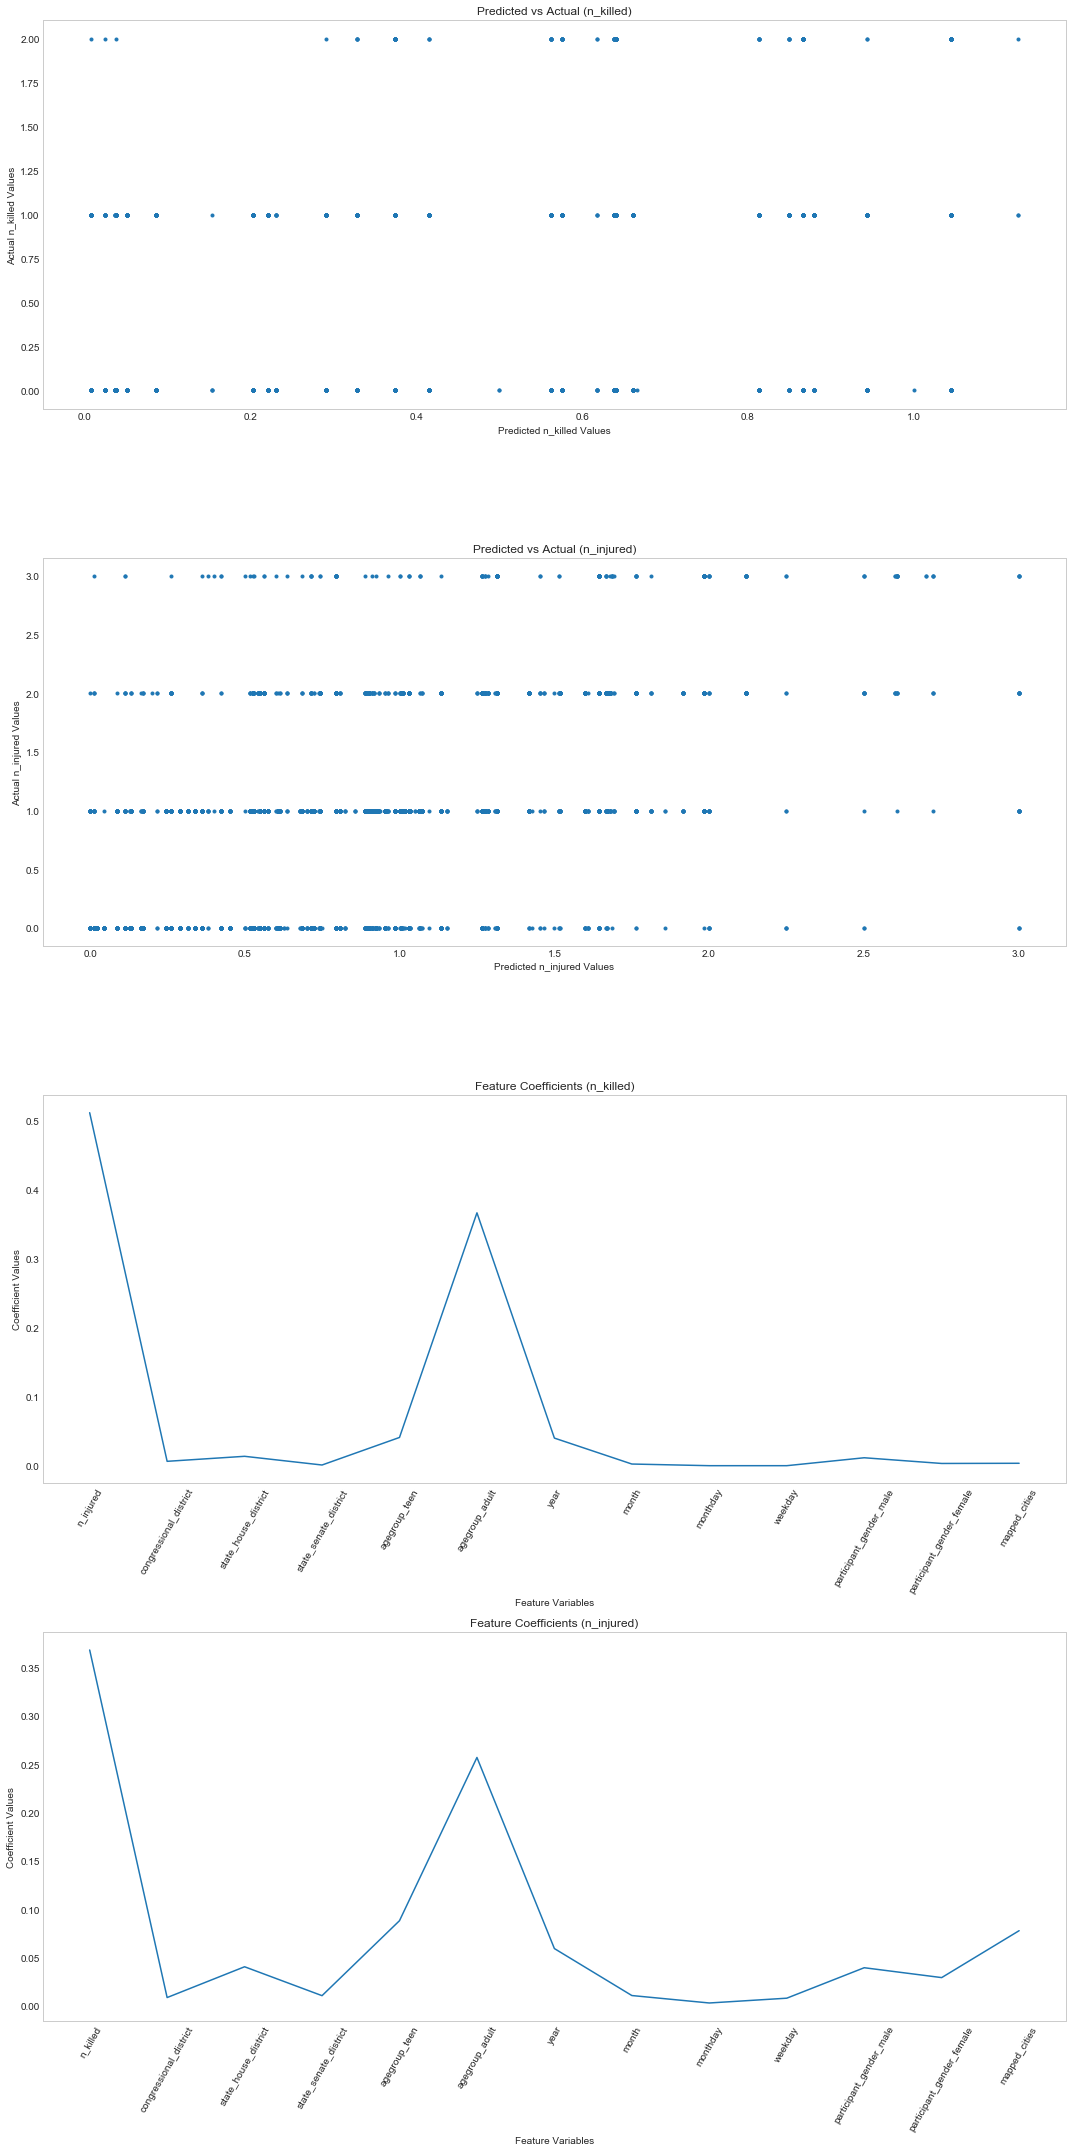

In [34]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
tree_coef = best_tree.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(nX_col)),tree_coef)
_ = plt.xticks(range(len(nX_col)),nX_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
tree_coef2 = best_tree2.named_steps['tree'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(nX2_col)),tree_coef2)
_ = plt.xticks(range(len(nX2_col)),nX2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the optimized Decision Tree model has shown improvement in both R-squared (0.5348 with optimization vs 0.5220 without) and RMSE (0.3304 vs 0.3473). 


- Looking at the predicted vs actual plot, this model has become better at correctly predicting when the number of people killed is 0 but still needs to improve on correctly predicting when the true value is greater than 0. The model also put more weight on the mapped_primary feature moreso than before as its feature importance has increased to over 0.5. 


- For *n_injured*, the optimized Decision Tree model showed a worse result in R-Squared (0.4666 with optimization vs 0.4713) and an improvement in RMSE (0.4898 vs 5688).


- The predicted vs actual plot shows that the model works best when predicting number of people injured is actually 0, but does a poor job at correctly predicting incidents where the number is greater than 0. The feature coefficients plot shows about the same plot as without the optimization, although it has put more weight on the mapped_primary feature. 


- Next, let's try using the Random Forest Regressor.

In [35]:
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(nX, ny, test_size = 0.3, random_state = 6)
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv.fit(X_train, y_train)
print('The best score is (n_killed):{0:.4f}'.format(rscv.best_score_))
print('The best parameters are (n_killed):',rscv.best_params_)

# Do the same for n_injured
steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline2 = Pipeline(steps)
X_train2, X_test2, y_train2, y_test2 = train_test_split(nX2, ny2, test_size = 0.3, random_state = 6)
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
    }
rscv2 = RandomizedSearchCV(pipeline2, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv2.fit(X_train2, y_train2)
print('\nThe best score is (n_injured):{0:.4f}'.format(rscv2.best_score_))
print('The best parameters are (n_injured):',rscv2.best_params_)

The best score is (n_killed):0.5654
The best parameters are (n_killed): {'rf__n_estimators': 89, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 4, 'rf__max_depth': 26, 'rf__bootstrap': True}

The best score is (n_injured):0.5085
The best parameters are (n_injured): {'rf__n_estimators': 91, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 1, 'rf__max_depth': 15, 'rf__bootstrap': True}


In [36]:
best_rf = rscv.best_estimator_
y_pred = best_rf.predict(X_test)
print('\nR-squared (n_killed): {0:.4f}'.format(best_rf.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error (n_killed): {0:.4f}".format(rmse))
cv_scores = cross_val_score(best_rf,nX,ny,cv=10)
print("Average 10-Fold CV Score (n_killed): {0:.4f}".format(np.mean(cv_scores)))

# Do the same for n_injured
best_rf2 = rscv2.best_estimator_
y_pred2 = best_rf2.predict(X_test2)
print('\nR-squared (n_injured): {0:.4f}'.format(best_rf2.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2,y_pred2))
print("Root Mean Squared Error (n_injured): {0:.4f}".format(rmse2))
cv_scores2 = cross_val_score(best_rf2,nX2,ny2,cv=10)
print("Average 10-Fold CV Score (n_injured): {0:.4f}".format(np.mean(cv_scores2)))


R-squared (n_killed): 0.5718
Root Mean Squared Error (n_killed): 0.3137
Average 10-Fold CV Score (n_killed): 0.5379

R-squared (n_injured): 0.5245
Root Mean Squared Error (n_injured): 0.4680
Average 10-Fold CV Score (n_injured): 0.4774


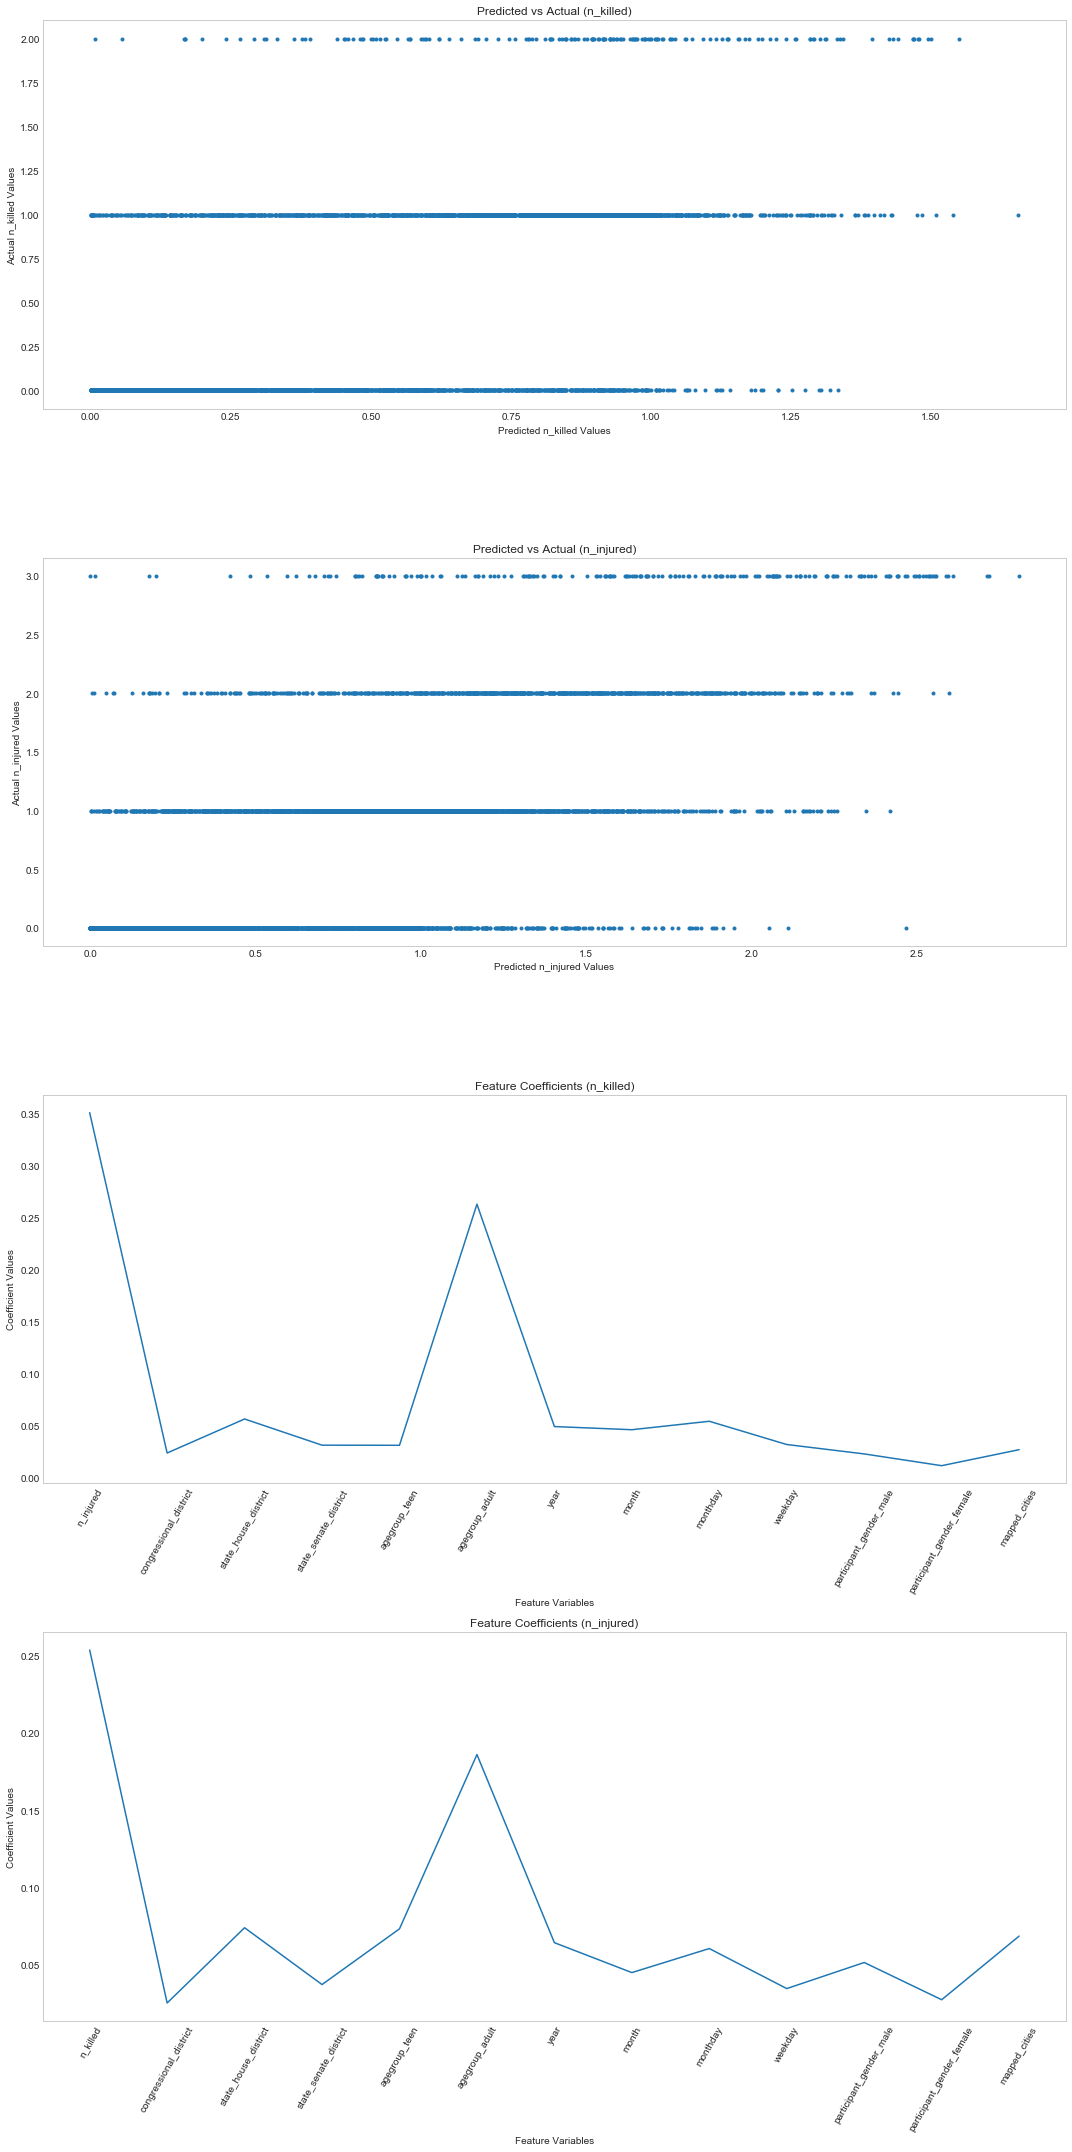

In [37]:
fig = plt.figure(figsize = (15,30))
_ = plt.subplot(4,1,1)
_ = plt.scatter(y_pred,y_test, marker = '.')
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (n_killed)')

# Do the same for n_injured
_ = plt.subplot(4,1,2)
_ = plt.scatter(y_pred2,y_test2, marker = '.')
_ = plt.xlabel('Predicted n_injured Values')
_ = plt.ylabel('Actual n_injured Values')
_ = plt.title('Predicted vs Actual (n_injured)')

# Plot the coefficients 
rf_coef = best_rf.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,3)
_ = plt.plot(range(len(nX_col)),rf_coef)
_ = plt.xticks(range(len(nX_col)),nX_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_killed)')

# Do the same for n_injured
rf_coef2 = best_rf2.named_steps['rf'].feature_importances_
_ = plt.subplot(4,1,4)
_ = plt.plot(range(len(nX2_col)),rf_coef2)
_ = plt.xticks(range(len(nX2_col)),nX2_col,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (n_injured)')

_ = plt.tight_layout()

- For *n_killed*, the optimized Random Forest model has shown improvement in both R-squared (0.5718 with optimization vs 0.5398 without) and RMSE (0.3137 vs 0.3401). It also has better results than the optimized Decision Tree model.


- As was the case for the optimized Decision Tree model, the optimized Random Forest model does a better job at predicting cases where there were no deaths but is not efficient for cases where there's at least 1 death. However, it definitely is more accurate than the first iteration of the random forest model without optimization due to the fact that there are no longer outliers. The feature coefficients plot also looks pretty similar to that of the optimized Decision Tree model.


- For *n_injured*, the optimized Random Forest model showed improvement in R-Squared (0.5245 with optimization vs 0.5110) and in RMSE (0.4680 vs 0.5379). Just like n_killed, this model has proven to be more successful for n_injured than the Decision Tree model.


- The predicted vs actual plot shows a number of points that spread out between 1 and 3 when the true value is 1. This indicates the uneffectiveness of this model but the fact that it received higher R-Squared and RMSE scores means that it has a greater concentration of points in the regions with correctly predicted values. For example, while there are many predicted values between 1 and 2 when the true value is 1, the majority of them are actually close to 1. 

**7. Model Conclusion**

As a result of testing various different models and removing outliers to improve the results, the optimized Random Forest classifier has proven to be the most effective model for predicting the number of people killed *and* the number of people injured in gun incidents. The model produced a 0.5718 R-Squared and 0.3137 RMSE for predicting the number of people killed. It also produced a 0.5245 R-Squared and 0.4680 RMSE for the predicting number of people injured. The ensemble methods performed better overall than the linear regressors mainly due to the fact that using linear regression resulted in negative predicted values which is impossible in this case. 

The most influential feature variables have been the number of casualties (number of injuries and number of killed) and the number of adults. This is likely due to the fact that if the average shooting incident has a constant number of people who are shot at, they will either be injured or dead. The number of adults also has a big influence because incidents with adults have a higher casualty rate than incidents with children or teens. It also has a positive correlation with the number of deaths and injuries, where more adult participants in shooting incidents tend to result in more casualties. 

Other noticeable predictor variables were the year, day of the month and the cities. As seen from the exploratory data analysis, the overall number of casualties have gone up each year so incidents in 2017 or 2018 would most likely have more deaths or injuries than incidents in 2013 or 2014. The day of the month is more interesting since the number of casualties seem fairly evenly distributed among the days of the month, with the exception of 31st (since only a handful of months have 31 days). The city in which the shooting incident took place can also have an impact because of the different casualty rates from city to city. Based on the data, the machine would interpret an incident in Chicago to most likely have more deaths than a city from Oakland. 

In [41]:
model_dict = {
    'Model for n_killed':['Base-line','Linear Regression','Linear Regression w/ Lasso', 'Linear Regression w/Ridge',
            'Decision Tree', 'Random Forest', 'Decision Tree w/ Optimization', 'Random Forest w/ Optimization'
            ],
    'R-Squared':[-0.0001, 0.3193, 0.3123, 0.2973, 0.5220, 0.5398, 0.5348, 0.5718],
    'RMSE':[0.5067, 0.4123, 0.4112, 0.4144, 0.3473, 0.3401, 0.3304, 0.3137]
}
pd.DataFrame(model_dict).set_index('Model for n_killed').sort_values(by='R-Squared', ascending = False)

,R-Squared,RMSE
Model for n_killed,,
Random Forest w/ Optimization,0.5718,0.3137
Random Forest,0.5398,0.3401
Decision Tree w/ Optimization,0.5348,0.3304
Decision Tree,0.5220,0.3473
Linear Regression,0.3193,0.4123
Linear Regression w/ Lasso,0.3123,0.4112
Linear Regression w/Ridge,0.2973,0.4144
Base-line,-0.0001,0.5067


In [40]:
model_dict2 = {
    'Model for n_injured':['Base-line','Linear Regression','Linear Regression w/ Lasso', 'Linear Regression w/Ridge',
            'Decision Tree', 'Random Forest', 'Decision Tree w/ Optimization', 'Random Forest w/ Optimization'
            ],
    'R-Squared':[0,0.4207, 0.4279, 0.4437, 0.4713, 0.5110, 0.4666, 0.5245],
    'RMSE':[0.7654, 0.6005, 0.5809, 0.5993, 0.5688, 0.5379, 0.4898, 0.4680]
}
pd.DataFrame(model_dict2).set_index('Model for n_injured').sort_values(by='R-Squared', ascending = False)

,R-Squared,RMSE
Model for n_injured,,
Random Forest w/ Optimization,0.5245,0.4680
Random Forest,0.5110,0.5379
Decision Tree,0.4713,0.5688
Decision Tree w/ Optimization,0.4666,0.4898
Linear Regression w/Ridge,0.4437,0.5993
Linear Regression w/ Lasso,0.4279,0.5809
Linear Regression,0.4207,0.6005
Base-line,0.0000,0.7654
